<a href="https://colab.research.google.com/github/Lucas-Monteiro-Henriques/Implement_VISIONTS/blob/main/MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importei MAE do Facebook

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import subprocess
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from skimage.transform import resize
import urllib.request


import torch
import timm
from timm.models.vision_transformer import PatchEmbed, Block
np.float = float

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
repo_dir = 'mae'
repo_url = 'https://github.com/facebookresearch/mae.git'

if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    if not os.path.exists('mae'):
        !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    if not os.path.exists(repo_dir):
        print(f'Cloned in : {repo_dir}')
        subprocess.run(['git', 'clone', repo_url], check=True)
    else:
        print(f'Repository already exists in {repo_dir}')

Repository already exists in mae


In [3]:
if os.path.exists('pytorch_image_models'):
    pass
else:
    !git clone https://github.com/huggingface/pytorch-image-models.git
    os.rename('pytorch-image-models', 'pytorch_image_models') #renomeia a pasta porque dá conflito nos imports


In [4]:
# from pytorch_image_models.timm.models.vision_transformer import PatchEmbed, Block

In [5]:
mae_path = os.path.abspath("mae")
if mae_path not in sys.path:
    sys.path.insert(0, mae_path)

from models_mae import mae_vit_base_patch16

In [6]:
model = mae_vit_base_patch16()

Implementação do Algoritmo de transformação das séries temporais 1D para 2D

In [7]:
df = pd.read_csv("https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTm1.csv")


serie = df["OT"].values[:30000]

acf_vals = acf(serie, nlags=min(500, len(serie)//2), fft=True)

lags = np.arange(1, len(acf_vals))
acf_sem_lag0 = acf_vals[1:]
peaks, _ = find_peaks(acf_sem_lag0, height=0.1)

if len(peaks) == 0:
    P = 1
else:
    P = peaks[0] + 1

print(f"Periodicidade estimada: {P}")

L = (len(serie) // P) * P
serie_cortada = serie[:L]


matriz_2d = serie_cortada.reshape(P, L // P)
print("Matriz 2D:\n", matriz_2d)

Periodicidade estimada: 86
Matriz 2D:
 [[30.53100014 30.45999908 30.03800011 ... 30.74200058 31.02300072
  31.16399956]
 [31.72599983 31.375      31.79700089 ... 29.61599922 28.77199936
  28.91300011]
 [29.40500069 29.12400055 29.12400055 ... 33.62599945 33.13299942
  32.92200089]
 ...
 [15.0539999  14.70300007 14.63199997 ... 18.14999962 18.43099976
  18.92300034]
 [18.92300034 18.71199989 18.50099945 ... 16.25       16.88299942
  16.53199959]
 [16.18000031 15.82800007 15.68700027 ... 16.60199928 15.89799976
  14.63199997]]


Normalization do Iraw


In [8]:
import numpy as np
from statistics import mean
desvio_padrao = np.std(matriz_2d)
print(desvio_padrao)
mean  = np.mean(matriz_2d)
print(mean)

9.771036373470926
16.98072094700392


In [9]:
r = 0.4
Inorm = r * (matriz_2d - mean)/ desvio_padrao
print(Inorm)

[[ 0.55471206  0.55180546  0.53452996 ...  0.56334985  0.57485324
   0.58062535]
 [ 0.60363214  0.58926314  0.60653873 ...  0.51725437  0.48270329
   0.48847548]
 [ 0.50861666  0.49711327  0.49711327 ...  0.68141302  0.66123092
   0.65259321]
 ...
 [-0.07887479 -0.09324378 -0.09615033 ...  0.04786713  0.05937052
   0.0795117 ]
 [ 0.0795117   0.07087391  0.06223612 ... -0.02991375 -0.00400046
  -0.01836945]
 [-0.03277935 -0.0471893  -0.05296145 ... -0.01550385 -0.0443237
  -0.09615033]]


Esse é o algorimo do Alignment, mas não foi testado, pois o MAE do Facebook precisa ser alterado na parte da mascara


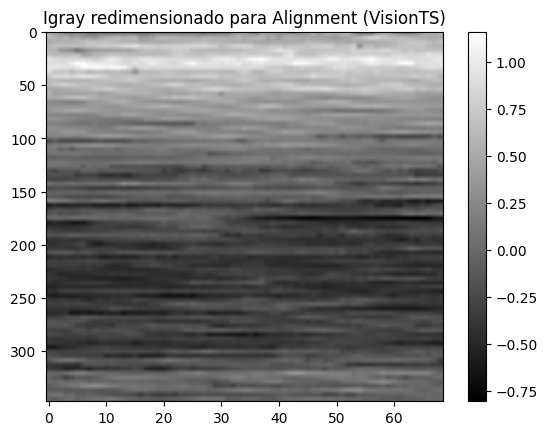

Shape original Inorm: (86, 348)
Shape Igray: (86, 348, 3)
Shape Igray_resized: (348, 69)
Shape Igray_resized_3ch: (348, 69, 3)


In [10]:
L = 96
H = 96
c = 0.4
S = 1
N = max(Inorm.shape)

# Etapa 1: Render Igray (imagem 3 canais iguais)
Igray = np.stack([Inorm] * 3, axis=-1)

# Etapa 2: Alignment
n = int(np.floor(c * N * L / (L + H)))  # número de patches visíveis na horizontal
target_shape = (N * S, n * S)           # shape final da imagem após resize

# Resize Igray (mantendo apenas 1 canal para simplificar o MAE)
Igray_resized = resize(Inorm, target_shape, order=1, mode='reflect', anti_aliasing=False)

# Converter para imagem 3 canais (opcional, dependendo do input do MAE)
Igray_resized_3ch = np.stack([Igray_resized] * 3, axis=-1)

# Visualização
plt.imshow(Igray_resized, cmap='gray', aspect='auto')
plt.title("Igray redimensionado para Alignment (VisionTS)")
plt.colorbar()
plt.show()

# Print das formas para verificação
print("Shape original Inorm:", Inorm.shape)
print("Shape Igray:", Igray.shape)
print("Shape Igray_resized:", Igray_resized.shape)
print("Shape Igray_resized_3ch:", Igray_resized_3ch.shape)


Funções do MAE

Vizulização da imagem

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7945514505997496..1.1359596494640953].


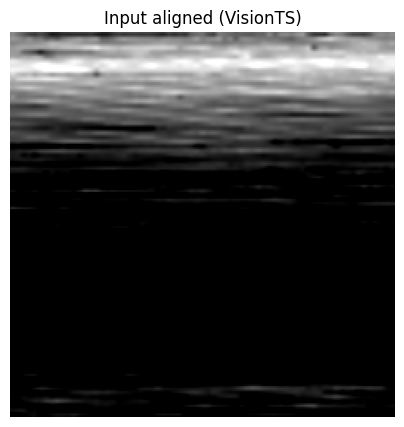

In [11]:
# Suponha que você já tem:
# Igray_resized_3ch com shape (29, 8, 3) — imagem com 3 canais e normalizada (VisionTS-style)

# Etapa 1: Redimensionar para 224 x 224 (como esperado pelo MAE)
img = resize(Igray_resized_3ch, (224, 224), order=1, mode='reflect', anti_aliasing=False)

# Etapa 2: Visualização opcional (sem normalizar com ImageNet)
plt.rcParams['figure.figsize'] = [5, 5]
plt.imshow(img)
plt.title("Input aligned (VisionTS)")
plt.axis('off')
plt.show()

# Se for usar a função run_one_image, ela espera um tensor com valores normalizados já
# Portanto você pode usar:
img = torch.tensor(img, dtype=torch.float32)


Download dos pesos de Modelo


In [12]:
# MAE com decoder
if False:
    !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth

if True:
    url = 'https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_base.pth'
    dest = 'mae_visualize_vit_base.pth'

    if not os.path.exists(dest):
        print('Downloading MAE with decoder...')
        urllib.request.urlretrieve(url, dest)
    else:
        pass


In [13]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    from models_mae import mae_vit_base_patch16
    model = mae_vit_base_patch16()

    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image_from_aligned_image(Igray_resized_3ch, model, L=96, H=192, c=0.4):
    """
    Igray_resized_3ch: imagem com 3 canais (já alinhada), shape (H, W, 3), valores já normalizados
    model: modelo MAE do repo da Meta (Vit-base etc)
    L, H, c: hiperparâmetros do VisionTS
    """
    # 1. Redimensionar para 224x224 (como esperado pelo MAE)
    img = resize(Igray_resized_3ch, (224, 224), order=1, mode='reflect', anti_aliasing=False)
    x = torch.tensor(img, dtype=torch.float32).unsqueeze(0)       # [1, H, W, C]
    if False:
        x = torch.einsum('nhwc->nchw', x).cuda()                      # [1, 3, 224, 224]
    if True:
        x = torch.einsum('nhwc->nchw', x).to(device)

    # 2. Criar máscara estruturada: lado direito mascarado
    patch_size = model.patch_embed.patch_size[0]         # geralmente 16
    num_patches_row = x.shape[2] // patch_size           # 224 / 16 = 14
    num_patches = num_patches_row ** 2                   # 14 x 14 = 196

    N = num_patches_row
    n = int(np.floor(c * N * L / (L + H)))                # número de colunas visíveis

    # Criar máscara: 0 = visível (esquerda), 1 = mascarado (direita)
    mask = torch.ones(num_patches, device=x.device)
    for row in range(N):
        for col in range(N):
            idx = col * N + row  # column-major
            if row >= 15 - n :      # as primeiras colunas serão mascaradas
                mask[idx] = 1  # mascarado
            else:
                mask[idx] = 0 
    mask = mask.unsqueeze(0)  # [1, num_patches]
   # 90º anti-horário
    print(mask.view(N, N))
    mask = mask.reshape(1, N * N) 
    
    # 3. Forward com máscara estruturada
    # 3. Forward com máscara estruturada
    # 3. Forward com máscara estruturada
    with torch.no_grad():
        if False:
            loss, y, _ = model(x.float(), mask=mask)         # usamos mask diretamente
        if True:
            loss, y, _ = model(x.float())
        y = model.unpatchify(y)                          # [1, 3, H, W]
        if False:
            y = torch.einsum('nchw->nhwc', y).cpu().numpy()
        if True:
            y = torch.einsum('nchw->nhwc', y).cpu()

        mask_recon = mask.unsqueeze(-1).repeat(1, 1, patch_size ** 2 * 3)
        mask_recon = model.unpatchify(mask_recon)
        mask_recon = torch.einsum('nchw->nhwc', mask_recon).cpu()

    x_vis = x.cpu()
    x_vis = torch.einsum('nchw->nhwc', x_vis)

    im_masked = x_vis * (1 - mask_recon)
    im_paste = x_vis * (1 - mask_recon) + y * mask_recon



    # 4. Visualização
    plt.rcParams['figure.figsize'] = [24, 6]
    plt.subplot(1, 4, 1); show_image(x_vis[0], "original")
    plt.subplot(1, 4, 2); show_image(im_masked[0], "structured mask")
    plt.subplot(1, 4, 3); show_image(y[0], "reconstruction")
    plt.subplot(1, 4, 4); show_image(im_paste[0], "reconstruction + visible")
    plt.show()

    return y[0], im_paste[0]  # retorno da imagem reconstruída (H, W, 3)

In [14]:
# Carrega o modelo base

from models_mae import mae_vit_base_patch16

chkpt_dir = 'mae_visualize_vit_base.pth'
model = mae_vit_base_patch16()
checkpoint = torch.load(chkpt_dir, map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

# Enviar para GPU
model.eval()
# model.cuda()

<All keys matched successfully>


MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_features=768, out_features=512, bias=

MAE with pixel reconstruction:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


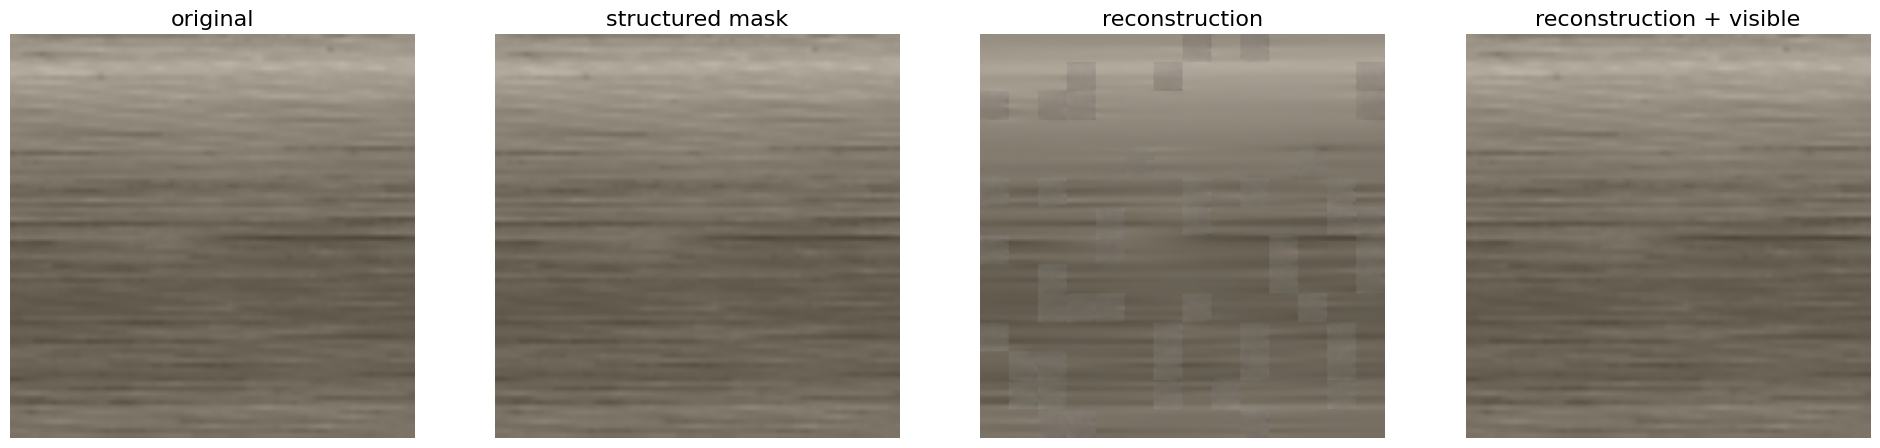

In [15]:
# make random mask reproducible (comment out to make it change)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # usa cuda ou cpu
model = model.to(device)

# Garante reprodutibilidade na máscara aleatória
torch.manual_seed(2)

Igray_resized_3ch_tensor = torch.from_numpy(Igray_resized_3ch).float().to(device)
print('MAE with pixel reconstruction:')
reconstructed_image, imagem_correta = run_one_image_from_aligned_image(Igray_resized_3ch, model)


Algoritmo de reconstrução, mudar o L e H  em def reconstruct_and_evaluate_forecast para
Tabela oficial dos resultados (extraída do artigo)


In [16]:
# 📊 Tabela oficial dos resultados no dataset ETTm1:
# -----------------------------------------------------------
# | L   | H   | MSE ↓   | MAE ↓   |
# |-----|-----|---------|---------|
# | 96  | 96  | 0.234   | 0.368   |
# | 96  | 192 | 0.286   | 0.411   |
# | 96  | 336 | 0.287   | 0.414   |
# | 96  | 720 | 0.365   | 0.470   |
# -----------------------------------------------------------
#

In [17]:
reconstrucao = imagem_correta.numpy() * desvio_padrao/r + mean 
print(reconstrucao)

[[[29.760563 29.760563 29.760563]
  [30.45408  30.45408  30.45408 ]
  [29.931429 29.931429 29.931429]
  ...
  [30.085169 30.085169 30.085169]
  [30.352303 30.352303 30.352303]
  [29.997837 29.997837 29.997837]]

 [[29.28888  29.28888  29.28888 ]
  [30.093658 30.093658 30.093658]
  [29.487158 29.487158 29.487158]
  ...
  [30.24847  30.24847  30.24847 ]
  [30.559433 30.559433 30.559433]
  [30.14681  30.14681  30.14681 ]]

 [[30.140842 30.140842 30.140842]
  [30.744658 30.744658 30.744658]
  [30.289608 30.289608 30.289608]
  ...
  [29.95351  29.95351  29.95351 ]
  [30.18531  30.18531  30.18531 ]
  [29.87773  29.87773  29.87773 ]]

 ...

 [[16.93785  16.93785  16.93785 ]
  [16.97265  16.97265  16.97265 ]
  [16.946424 16.946424 16.946424]
  ...
  [16.512617 16.512617 16.512617]
  [16.45417  16.45417  16.45417 ]
  [16.531725 16.531725 16.531725]]

 [[15.643983 15.643983 15.643983]
  [15.97739  15.97739  15.97739 ]
  [15.726127 15.726127 15.726127]
  ...
  [16.63925  16.63925  16.63925 ]
  [1

In [18]:
print("im_paste_hw3:", type(reconstrucao), getattr(reconstrucao, "shape", None))
print("original_Inorm:", type(matriz_2d), getattr(matriz_2d, "shape", None))


im_paste_hw3: <class 'numpy.ndarray'> (224, 224, 3)
original_Inorm: <class 'numpy.ndarray'> (86, 348)


In [19]:
def reconstruct_and_evaluate_forecast(
    y_reconstructed, original_Inorm, L=96, H=96, start_idx=None, flatten_order='C'
):
    import numpy as np
    from skimage.transform import resize
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # 1) Reconstrução -> grayscale -> volta ao shape original
    recon_gray = y_reconstructed.mean(axis=-1)
    recon_back = resize(
        recon_gray, original_Inorm.shape, order=1, mode='reflect',
        anti_aliasing=False, preserve_range=True
    )

    P, T = original_Inorm.shape
    recon_2d  = recon_back.reshape(P, T)
    target_2d = original_Inorm.reshape(P, T)

    # 2) Define o corte (mantido)
    if start_idx is not None:
        forecast_start = int(max(0, min(start_idx, T-1)))
        pred_steps = T - forecast_start
    else:
        pred_steps = max(1, min(int(H), T))
        forecast_start = T - pred_steps

    # 3) z = target até forecast_start | recon do forecast_start ao fim (mantido)
    z = target_2d.copy()
    z[:, forecast_start:] = recon_2d[:, forecast_start:]

    # 4) MÉTRICAS APENAS NO ÚLTIMO H DA SÉRIE 1D
    target_1d = target_2d.ravel(order=flatten_order)
    recon_1d  = recon_2d.ravel(order=flatten_order)
    T_series  = target_1d.size
    H_eff     = int(min(max(1, H), T_series))
    eval_start = T_series - H_eff  # ex.: 10000-96 = 9904

    y_t_lastH = target_1d[eval_start:]
    y_p_lastH = recon_1d[eval_start:]

    mse = mean_squared_error(y_t_lastH, y_p_lastH)
    mae = mean_absolute_error(y_t_lastH, y_p_lastH)

    # recorte para plot/uso (mantido)
    recon_forecast = recon_2d[:, forecast_start:]

    print(f"[forecast] T_cols={T}, start_idx={forecast_start}, pred_steps={pred_steps}")
    print(f"[métricas último H] série_total={T_series}, H={H_eff}, eval_start={eval_start} "
          f"-> MSE={mse:.6f} | MAE={mae:.6f}")

    # agora retornamos também os vetores usados no MSE/MAE e o eval_start
    return z, recon_forecast, mse, mae, y_t_lastH, y_p_lastH, eval_start


[forecast] T_cols=348, start_idx=156, pred_steps=192
[métricas último H] série_total=29928, H=192, eval_start=29736 -> MSE=0.763240 | MAE=0.719087


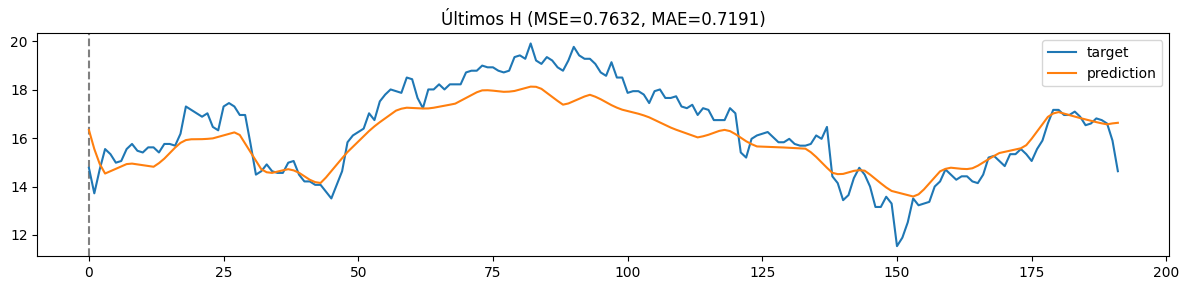

In [20]:
z, recon_fc, mse, mae, y_t_lastH, y_p_lastH, eval_start = reconstruct_and_evaluate_forecast(
    reconstrucao, matriz_2d, H=192, flatten_order='C'
)

# plot rápido só do trecho avaliado:
import numpy as np, matplotlib.pyplot as plt
x = np.arange(len(y_t_lastH))
plt.figure(figsize=(12,3))
plt.axvline(0, ls='--', c='gray')
plt.plot(x, y_t_lastH, label='target')
plt.plot(x, y_p_lastH, label='prediction')
plt.title(f'Últimos H (MSE={mse:.4f}, MAE={mae:.4f})')
plt.legend(); plt.tight_layout(); plt.show()
